**Drive de google.colab**

In [ ]:
# Montar Drive (si no está montado)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importación y configuración.**

In [ ]:
# === IMPORTS ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.signal import periodogram
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Ruta de origen y lectura
ruta = "/content/drive/MyDrive/Proyecto Integrador TEC 2025/EDA/df_baseline.csv"
df = pd.read_csv(ruta)

**Visualización previa**

In [ ]:
df.head(5)

,Año,Semana_num,Fecha,Entidad,Nuevos_Casos,Acum_H,Acum_M
0,2014,2,2014-01-05,Aguascalientes,0,0,0
1,2014,3,2014-01-12,Aguascalientes,0,0,0
2,2014,4,2014-01-19,Aguascalientes,1,0,1
3,2014,5,2014-01-26,Aguascalientes,0,0,1
4,2014,6,2014-02-02,Aguascalientes,0,0,1


**Detección de columnas**

In [ ]:
# Detectar columnas (fecha/target)
cols_low = {c.lower(): c for c in df.columns}
date_cands = [k for k in cols_low if any(w in k for w in ["fecha","date","ds","time"])]
tgt_cands  = [k for k in cols_low if any(w in k for w in ["nuevos_casos","casos","target","y","count"]) and "por" not in k]

date_col = cols_low[date_cands[0]] if date_cands else df.columns[0]
if tgt_cands:
    target_col = cols_low[tgt_cands[0]]
else:
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    target_col = num_cols[-1] if num_cols else df.columns[-1]

# Normalizar fechas y sumar por fecha (nacional)
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = (df.dropna(subset=[date_col])
        .sort_values(date_col)
        .groupby(date_col, as_index=False)[target_col].sum())
print(f"Usando columnas -> fecha='{date_col}', target='{target_col}'")
df.head()

Usando columnas -> fecha='Fecha', target='Nuevos_Casos'


,Fecha,Nuevos_Casos
0,2014-01-05,11
1,2014-01-12,89
2,2014-01-19,127
3,2014-01-26,114
4,2014-02-02,159


*El script detectó correctamente las columnas Fecha y Nuevos_Casos, convirtió las fechas a datetime, ordenó y agregó a nivel nacional sumando por fecha.*

In [ ]:
# Inferir frecuencia aproximada y resamplear a semanal si corresponde
if len(df) >= 3:
    med_days = df[date_col].diff().dropna().dt.days.median()
else:
    med_days = np.nan

def to_weekly(_df):
    return (_df.set_index(date_col)
               .resample("W-SUN")[target_col].sum()
               .asfreq("W-SUN"))

if np.isnan(med_days) or med_days <= 2:
    freq = "W"; S = 52
    y = to_weekly(df)
elif med_days <= 10:
    freq = "W"; S = 52
    y = df.set_index(date_col).asfreq("W-SUN")[target_col]
    y = y.interpolate(limit_direction="both")
elif med_days <= 40:
    freq = "M"; S = 12
    y = df.set_index(date_col).asfreq("M")[target_col]
    y = y.interpolate(limit_direction="both")
    # para mantener foco semanal, pasamos a semanal sumando por semana
    y = to_weekly(y.reset_index().rename(columns={y.name: target_col, "index": date_col}))
    S = 52
else:
    # anual/irregular -> forzamos semanal por robustez de análisis
    freq = "A"; S = 52
    y = to_weekly(df)

y = y.astype(float)
n = len(y)
print(f"Frecuencia base usada: semanal (S={S}), n_obs={n}")
y.head()

Frecuencia base usada: semanal (S=52), n_obs=573


,Nuevos_Casos
Fecha,
2014-01-05,11.0
2014-01-12,89.0
2014-01-19,127.0
2014-01-26,114.0
2014-02-02,159.0


*Quedó frecuencia semanal (W-SUN) con S=52 y 573 observaciones. La serie se consolidó sumando por semana, quedando en float64 y comenzando el 2014-01-05.*

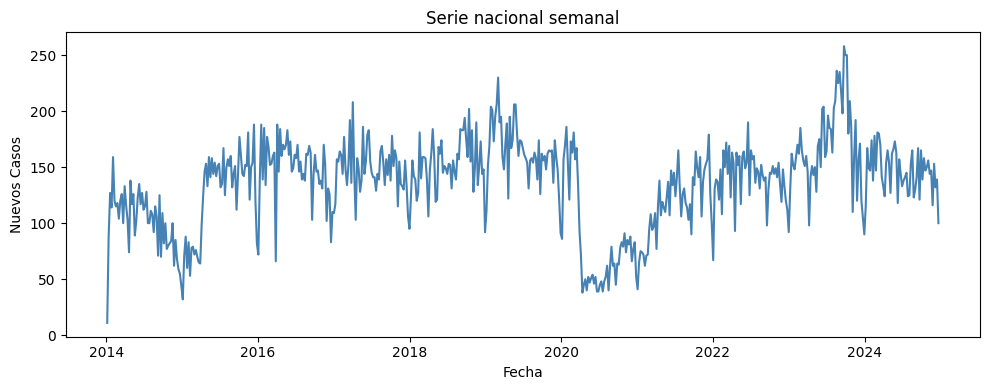

In [ ]:
# --- Serie ---
plt.figure(figsize=(10,4))
plt.plot(y.index, y.values, color='steelblue')
plt.title("Serie nacional semanal")
plt.xlabel("Fecha"); plt.ylabel("Nuevos Casos")
plt.tight_layout()
plt.show()

La serie semanal muestra tres fases bien marcadas. Entre 2014 y 2019 se observa un nivel medio estable (aprox. 120–170) con oscilaciones frecuentes y picos aislados. En 2020 aparece un quiebre abrupto a la baja, con valores mucho menores (del orden de 40–80) y menor variabilidad. Desde 2021 en adelante hay una recuperación del nivel con aumentos progresivos y una volatilidad mayor, alcanzando máximos superiores a los del primer período y luego una moderación hacia fines de 2024.

A lo largo de toda la serie se aprecian outliers positivos (picos puntuales) y cambios de varianza más contenida en 2020 y más alta después de 2021, mientras que la estacionalidad anual, si existe, es débil o irregular (no se repite un patrón nítido y constante año a año). *texto en cursiva*

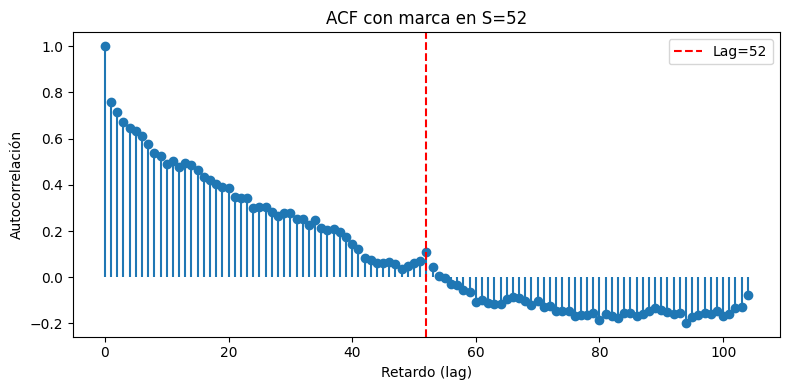

In [ ]:
S = 52  # periodo semanal
acf_vals = acf(y.fillna(method="ffill").fillna(method="bfill"), nlags=min(len(y)//2, S*2), fft=True)

plt.figure(figsize=(8,4))
lags = np.arange(len(acf_vals))
plt.stem(lags, acf_vals, basefmt=" ", linefmt="C0-", markerfmt="C0o")
plt.axvline(S, linestyle="--", color="red", label=f"Lag={S}")
plt.legend()
plt.title(f"ACF con marca en S={S}")
plt.xlabel("Retardo (lag)")
plt.ylabel("Autocorrelación")
plt.tight_layout()
plt.show()

*El gráfico ACF muestra una autocorrelación alta en los primeros retardos que va disminuyendo gradualmente, lo que indica una fuerte dependencia temporal entre semanas cercanas. El descenso lento sugiere la presencia de una tendencia persistente o de largo plazo en la serie. En el retardo 52 (una marca anual), la correlación es débil pero positiva, lo que apunta a una estacionalidad anual tenue, no completamente regular. Después de ese punto, las autocorrelaciones oscilan alrededor de cero, lo que refuerza la idea de que la serie tiene una componente estacional poco marcada y un componente de tendencia más relevante.*

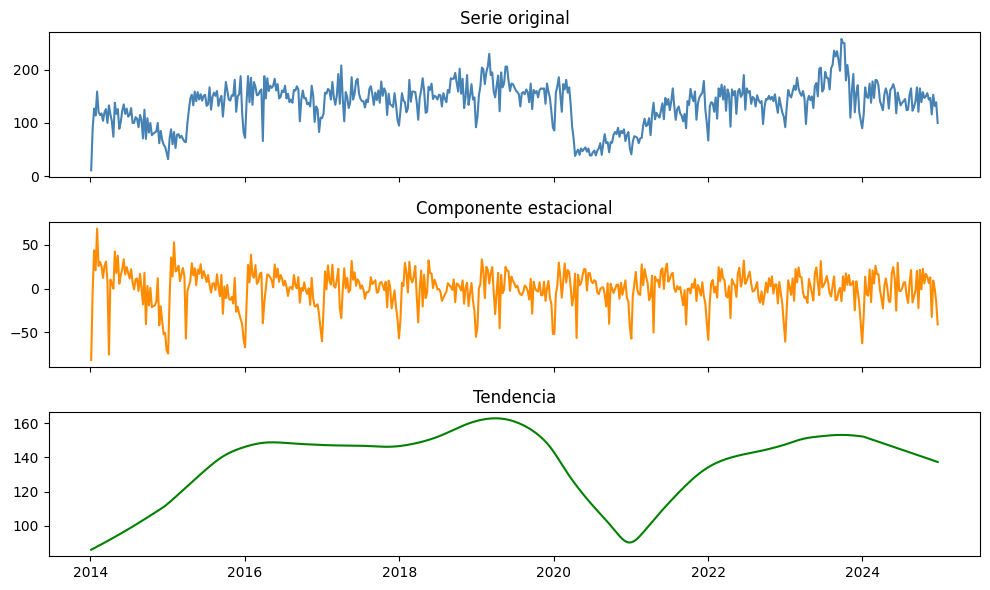

In [ ]:
if len(y) >= S*2:
    stl = STL(y, period=S, robust=True).fit()
    fig, axs = plt.subplots(3, 1, figsize=(10,6), sharex=True)

    axs[0].plot(y.index, y.values, color='steelblue')
    axs[0].set_title("Serie original")

    axs[1].plot(y.index, stl.seasonal.values, color='darkorange')
    axs[1].set_title("Componente estacional")

    axs[2].plot(y.index, stl.trend.values, color='green')
    axs[2].set_title("Tendencia")

    plt.tight_layout()
    plt.show()

*La descomposición STL revela que la serie presenta una tendencia clara y cambiante a lo largo del tiempo, con un crecimiento sostenido hasta 2019, una caída pronunciada durante 2020 y una recuperación progresiva desde 2021 que alcanza un nuevo pico hacia 2023-2024 antes de descender levemente.
La componente estacional muestra fluctuaciones anuales de magnitud moderada (±50 casos), regulares pero sin un patrón perfectamente repetitivo, lo que indica una estacionalidad leve e inestable. En conjunto, la serie está dominada por la tendencia de largo plazo más que por la estacionalidad, con variaciones de corto plazo que reflejan cambios coyunturales o eventos puntuales.*

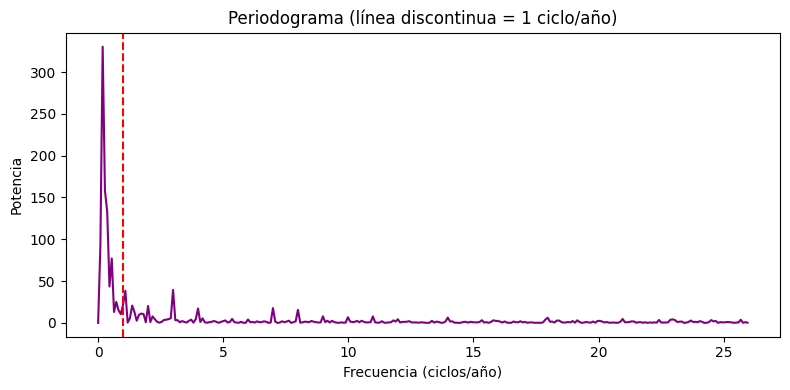

In [ ]:
from scipy.signal import periodogram

plt.figure(figsize=(8,4))
x = y.values - np.nanmean(y.values)
f, Pxx = periodogram(x, fs=52, scaling="spectrum", detrend="linear")
plt.plot(f, Pxx, color='purple')
plt.axvline(1.0, linestyle="--", color="red")  # 1 ciclo/año
plt.title("Periodograma (línea discontinua = 1 ciclo/año)")
plt.xlabel("Frecuencia (ciclos/año)")
plt.ylabel("Potencia")
plt.tight_layout()
plt.show()

*El periodograma muestra un pico principal de potencia en frecuencias muy bajas, lo que indica la presencia de tendencia de largo plazo como el componente dominante de la serie. La línea discontinua en 1 ciclo por año no coincide con un pico pronunciado, lo que confirma que la estacionalidad anual es débil o irregular. También se observan pequeños picos secundarios, pero con baja potencia, asociados a fluctuaciones menores y no a ciclos estables. En conjunto, el comportamiento espectral evidencia una serie más influida por variaciones lentas y estructurales que por repeticiones estacionales marcadas.*

**Resumen y síntesis (según la evidencia de serie, ACF, STL y periodograma)**

*En el análisis de la serie semanal se identificaron tres fases principales: un nivel estable entre 2014 y 2019, un quiebre abrupto a la baja durante 2020 y una recuperación posterior con mayor variabilidad desde 2021. Se observaron picos aislados y cambios en la varianza, con una estacionalidad anual débil e irregular.*  
*El análisis de la ACF evidenció una alta autocorrelación en los primeros retardos, indicando dependencia temporal de corto y mediano plazo, mientras que el retardo 52 mostró una señal débil. La descomposición STL confirmó que la tendencia es el componente dominante, y el periodograma reforzó esta conclusión al concentrar la potencia en frecuencias bajas.*

### modelos de series temporales sugeridos

De acuerdo con estos resultados, se determinó que los modelos más apropiados son aquellos que priorizan la **tendencia de largo plazo** y tratan la **estacionalidad como débil o variable**:

1. **Modelos estructurales (UCM)** con tendencia local (nivel y pendiente) y estacionalidad semanal opcional, incorporando posibles quiebres para los años 2020–2021.  
2. **SARIMAX o ARIMA con términos de Fourier**, adecuados para capturar memoria temporal sin imponer una estacionalidad fija.  
3. **Modelos ETS (Holt-Winters) con tendencia amortiguada**, que representan bien la variación progresiva y los cambios de nivel.  
4. **Enfoques híbridos STL + (ETS/ARIMA)**, útiles para separar una estacionalidad inestable de la componente tendencial.

En síntesis, el comportamiento de la serie sugiere el uso de **modelos con estructura flexible y predominio de la tendencia**, descartando enfoques puramente estacionales por la falta de periodicidad consistente.

**Generación del CSV para la etapa de modelado**

In [ ]:
# Crear DataFrame a partir de la serie semanal existente 'y'
df_modelos = y.reset_index().rename(columns={date_col: "Fecha", 0: "Nuevos_Casos"})
df_modelos.columns = ["Fecha", "Nuevos_Casos"]

# Definir la ruta de salida
ruta_salida = "/content/drive/MyDrive/Proyecto Integrador TEC 2025/EDA/nacional_semanal.csv"
os.makedirs(os.path.dirname(ruta_salida), exist_ok=True)

# Guardar el archivo
df_modelos.to_csv(ruta_salida, index=False)
print(f"Archivo CSV generado correctamente en:\n{ruta_salida}")
print(f"Rango temporal: {df_modelos['Fecha'].min().date()} → {df_modelos['Fecha'].max().date()} | {len(df_modelos)} observaciones")

Archivo CSV generado correctamente en:
/content/drive/MyDrive/Proyecto Integrador TEC 2025/EDA/nacional_semanal.csv
Rango temporal: 2014-01-05 → 2024-12-22 | 573 observaciones
